# **ABCDEats Inc. - Clustering Analysis**

# 1. Imports, Options and Ingestion

In [112]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA, FactorAnalysis
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

In [113]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [114]:
# Reading the csv data

data = pd.read_csv('/home/shadybea/OneDrive/General/Data Mining/Project/DM2425_ABCDEats_DATASET.csv')

# 2. Initial Transformations

In [115]:
_rename_dict = {
        'customer_region' : 'cust_region'
        , 'payment_method' : 'pay_method'
        , 'customer_age' : 'cust_age'
        , 'vendor_count' : 'n_vendor'
        , 'product_count' : 'n_product'
        , 'n_order' : 'n_order'
        , 'is_chain' : 'n_chain'
        , 'CUI_American' : 'american'
        , 'CUI_Asian' : 'asian'
        , 'CUI_Beverages' : 'beverages'
        , 'CUI_Cafe' : 'cafe'
        , 'CUI_Chicken Dishes' : 'chicken_dishes'
        , 'CUI_Chinese' : 'chinese'
        , 'CUI_Desserts' : 'desserts'
        , 'CUI_Healthy' : 'healthy'
        , 'CUI_Indian' : 'indian'
        , 'CUI_Italian' : 'italian'
        , 'CUI_Japanese' : 'japanese'
        , 'CUI_Noodle Dishes' : 'noodle_dishes'
        , 'CUI_OTHER' : 'other'
        , 'CUI_Street Food / Snacks' : 'street_food_snacks'
        , 'CUI_Thai' : 'thai'
}

# Rename the columns for easier reference
data.rename(columns=_rename_dict, inplace=True)

In [116]:
# Make the integer value of the customer hex values, the index. 
data['customer_id'] = data['customer_id'].apply(lambda x: int(x, 16))
# Set 'customer_id' as the index
data = data[~data['customer_id'].duplicated()].set_index('customer_id')

## 2.1. Missing Values

In [117]:
# Fill missing values for first_order
data.loc[data['first_order'].isna(), 'first_order'] = 0

In [118]:
# Fill missing values for HR_0
sum_week = data[[f"DOW_{n}" for n in range(7)]].sum(axis=1)
sum_day = data[[f"HR_{n}" for n in range(24)]].sum(axis=1)

data.loc[data['HR_0'].isna(), 'HR_0'] = (sum_week - sum_day)

## 2.2. Inconsistencies

### 2.2.1. Duplicate Values

In [119]:
data = data.drop_duplicates()

### 2.2.2. Inconsistent Values

In [120]:
# has at least one vendor
has_vendor = data['n_vendor'] != 0 

# has at least one product
has_product = data['n_product'] != 0 

# purchase must have been made on a valid dow
some_day = (data[[f"DOW_{n}" for n in range(7)]] != 0).any(axis = 1) 

# purchase must have been made at a valid hour
some_hour = (data[[f"HR_{n}" for n in range(24)]] != 0).any(axis = 1)  

# some type of cuisine must have been ordered
some_food = (data[data.columns[9:24]] != 0).any(axis = 1) 

# We find 156 such values
data[~(has_vendor & has_product & some_day & some_hour & some_food)].shape[0] 

data = data[(has_vendor & has_product & some_day & some_hour & some_food)]  # And we drop these values

### 2.2.3. Weird Values

In [121]:
# Customer Region
data.loc[data['cust_region'] == '-', 'cust_region'] = '8670'
data.loc[data['cust_region'].isin(['2440', '2490']), 'cust_region'] = '2400'

# Add the feature Customer CIty
data['cust_city'] = data['cust_region'].apply(lambda x: x[0])

In [122]:
# Last Promo
data.loc[data['last_promo'] == '-', 'last_promo'] = 'NO_PROMO'

## 2.3. Data Types

In [123]:
# Tidying up datatypes
for col in data.iloc[:, 0:9]:
    if col in ['last_promo', 'pay_method']:
        data[col] = data[col].astype(object)
    else:
        data[col] = data[col].astype('Int64')

for col in data.iloc[:, 9:24]:
    data[col] = data[col].astype(float)

for col in data.iloc[:, 24:]:
    data[col] = data[col].astype('Int64')

# 3. Feature Engineering

We create lists of features for easy reference.

In [124]:
# Categorical variables
non_metric_features = ['cust_region', 'last_promo', 'pay_method', 'cust_city']

# Hour of day variables
hour_features = data.columns[31:55].to_list()

# Day of week variables
day_features = data.columns[24:31].to_list()

# Cuisine features
cuisine_features = data.columns[9:24].to_list()

# Metric variables, that are not above
metric_features = data.columns.drop(non_metric_features).drop(hour_features).drop(day_features).drop(cuisine_features).to_list()

In [125]:
# Total amount spent by customer on all types of cuisine
data['total_amt'] = data[cuisine_features].sum(axis=1)

# Number of orders made by the customer
data['n_order'] = data[day_features].sum(axis=1)

# Amount spent on average per product
data['avg_amt_per_product'] = data['total_amt'] / data['n_product']

# Amount spent on average per order
data['avg_amt_per_order'] = data['total_amt'] / data['n_order']

# Amount spent on average per vendor
data['avg_amt_per_vendor'] = data['total_amt'] / data['n_vendor']

# Total days as customer
data['days_cust'] = data['last_order'] - data['first_order']

# Average days between orders
data['avg_days_to_order'] = data['days_cust'] / data['n_order']

# Days the customer is due, according to their average days between orders
data['days_due'] = 90 - data['last_order'] + data['avg_days_to_order']

# Percentage of orders placed to restaurants that are part of a chain
data['per_chain_order'] = data['n_chain'] / data['n_order']

# And we add these tese features to the metric features list.
metric_features.extend(
    [
        'n_order'
        , 'per_chain_order'
        ,'total_amt'
        , 'avg_amt_per_order'
        , 'avg_amt_per_product'
        , 'avg_amt_per_vendor'
        , 'days_cust'
        , 'avg_days_to_order'
        , 'days_due'
    ]
)

In [126]:
# Create a mask to check if each day column is populated
mask = data[[f'DOW_{i}' for i in range(7)]] > 0

# Sum over the mask to get the count of days with purchases for each row
data.loc[:, 'n_days_week'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_days_week')

In [127]:
# Create a mask to check if each hour column is populated
mask = data[hour_features] > 0

# Sum over the mask to get the count of hours with purchases for each row
data.loc[:, 'n_times_day'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_times_day')

In [128]:
# Flag customers who have purchased in more than one day
data['regular'] = (data['days_cust'] != 0)

non_metric_features.append('regular')

In [129]:
# Create a mask where values are greater than zero (indicating an order)
mask = data[cuisine_features] > 0

# Use mask to get the number of cuisines for each row
data.loc[:, 'n_cuisines'] = mask.sum(axis=1)

# Updating the metric_features_list
metric_features.append('n_cuisines')

In [130]:
# Dropping specified columns and getting remaining columns as a list
targets = data.drop(columns=[
    'cust_age'
    , 'first_order'
    , 'last_order'
    , 'days_cust'
    , 'days_due'
    , 'avg_days_to_order'
    , 'per_chain_order'
    , 'cust_region'
    , 'cust_city'
    , 'last_promo'
    , 'pay_method'
    , 'n_cuisines'
    , 'regular'
] + hour_features + day_features).columns.tolist()

# Initialize an empty DataFrame to store log-transformed columns
log_transformed = pd.DataFrame()

# Apply log1p to each column in targets and add it to log_transformed with the prefix 'log_'
for col in targets:
    log_transformed[f"log_{col}"] = np.log1p(data[col])

# We create a list of log_features to assist us in our exploration
log_features = log_transformed.columns.tolist()

# Concatenate the original DataFrame with the new log-transformed DataFrame
data = pd.concat([data, log_transformed], axis=1)

In [131]:
# Initialize dictionaries for feature groups with flags and relevant columns
feature_groups = {
    'foodie': ['n_vendor', 'n_product', 'n_order', 'n_cuisines'],
    'gluttonous': ['avg_amt_per_order', 'total_amt', 'n_chain'],
    'loyal': ['avg_amt_per_vendor'] + cuisine_features
}

# Create columns to hold the flags for each feature group
data['foodie_flag'] = 0
data['gluttonous_flag'] = 0
data['loyal_flag'] = 0

# Function to calculate IQR bounds
def calculate_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Assign flags for each feature group
for group, features in feature_groups.items():
    for feature in features:
        log_feature = f"log_{feature}"
        
        if feature == 'n_cuisines':
            log_feature = feature
        
        lower_bound, upper_bound = calculate_bounds(data.loc[(data['regular'] == 1) & (data[feature] > 0), log_feature])
        
        # Mark outliers for each group
        if group == 'foodie':
            data.loc[data['regular'] == 1, 'foodie_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'gluttonous':
            data.loc[data['regular'] == 1, 'gluttonous_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'loyal':
            data.loc[data['regular'] == 1, 'loyal_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)

# Display results
for group in ['foodie_flag', 'gluttonous_flag', 'loyal_flag']:
    print(f"Number of customers flagged as {group.split('_')[0]}:", data[group].sum())

non_metric_features.extend([
    'foodie_flag'
    ,'gluttonous_flag'
    ,'loyal_flag'
])

Number of customers flagged as foodie: 2852
Number of customers flagged as gluttonous: 647
Number of customers flagged as loyal: 467


In [132]:
def top_n(row, col_list, n):
    # Sort the specified columns in descending order
    sorted_row = row[col_list].sort_values(ascending=False)

    # Get the unique sorted values
    unique_sorted_values = sorted_row.unique()

    # Ensure there are enough unique values to determine the n-th largest
    if len(unique_sorted_values) >= n:
        nth_value = unique_sorted_values[n - 1]  # Get the n-th largest unique value

        # If the n-th value is 0, return None
        if nth_value == 0:
            return None
        
        # If n > 1, check for uniqueness against the (n-1)-th largest
        if n > 1:
            prev_value = unique_sorted_values[n - 2]  # (n-1)-th largest unique value
            # If nth_value is equal to the (n-1)-th value, we don't want to return it
            if nth_value == prev_value:
                return None
        
        # Return the index of the n-th largest value
        return sorted_row[sorted_row == nth_value].index[0]

    # Return None if conditions are not met
    return None

In [133]:
data['top_cuisine'] = data.apply(top_n, col_list=cuisine_features, n=1, axis=1)

non_metric_features.append('top_cuisine')

In [134]:
# Average amount spent per day as customer
data['avg_amt_per_day'] = np.round(data['total_amt'] / data['days_cust'], 4)

# Average number of products ordered per day as customer
data['avg_product_per_day'] = np.round(data['n_product'] / data['days_cust'], 4)

# Average number of orders per day as customer
data['avg_order_per_day'] = np.round(data['n_order'] / data['days_cust'], 4)

metric_features.extend([
    'avg_amt_per_day'
    ,'avg_product_per_day'
    ,'avg_order_per_day'
])

# 4. Preprocessing

Before starting the preprocessing efforts, there are some customers that can be perceived as outliers, namely the ones that were flagged as part of a group or non-regulars. Therefore, we create an auxiliary dataframe excluding these, which we will use in a fashion resembling a train-test split, where these are the training data.

In [135]:
# Create dataframe with only regular customers
data = data[data['regular'] == 1]

## 4.1. Missing Values

In [136]:
data.loc[data['cust_age'].isna(), 'cust_age'] = data['cust_age'].mean().astype('int')

## 4.2. Outliers

In [137]:
def filter_by_percentile(data, filters):
    conditions = []

    for col, bounds in filters.items():
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

        lower_percentile, upper_percentile = bounds

        if lower_percentile is not None:
            lower_bound = data[col].quantile(lower_percentile)
            conditions.append(data[col] >= lower_bound)
        if upper_percentile is not None:
            upper_bound = data[col].quantile(upper_percentile)
            conditions.append(data[col] <= upper_bound)

    if conditions:
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition &= condition
        return data[combined_condition]

    return data

# Define your filters
defined_filters = {
    **{col: (None, 0.999) for col in data.columns if 'log' in col}
}

data = filter_by_percentile(data, defined_filters)

## 4.3. Data Normalization

For this step, we create two datasets, one using StandardScaler and another using MinMaxScaler. The clustering efforts will be applied to both and we will then choose the one which yields the best results.

In [138]:
scaler = StandardScaler().set_output(transform='pandas')

# Explicitly cast each metric column to float64
for col in data.columns[~data.columns.isin(non_metric_features)].tolist():
    data[col] = data[col].astype('float64')

In [139]:
data.loc[:, ~data.columns.isin(non_metric_features)] = \
    scaler.fit_transform(data.loc[:, ~data.columns.isin(non_metric_features)])

## 4.4. Multidimensional Outliers

Now, Local Outlier Factor can be applied to remove the multidimensional outliers, since the data is scaled.

In [140]:
# Number of lines original dataset
lines_og = data.shape[0]

lof = LocalOutlierFactor(n_neighbors=5)
outlier_predictions = lof.fit_predict(data.loc[:, ~data.columns.isin(non_metric_features)])

# Mark outliers
data['Outlier'] = np.where(outlier_predictions == -1, True, False)

# Remove outliers
data = data[data['Outlier'] == False].drop(columns=['Outlier'])

In [141]:
print('Percentage of data kept after removing outliers:', 100 * np.round(data.shape[0] / lines_og, 4))

Percentage of data kept after removing outliers: 98.63


## 4.5. Feature Selection

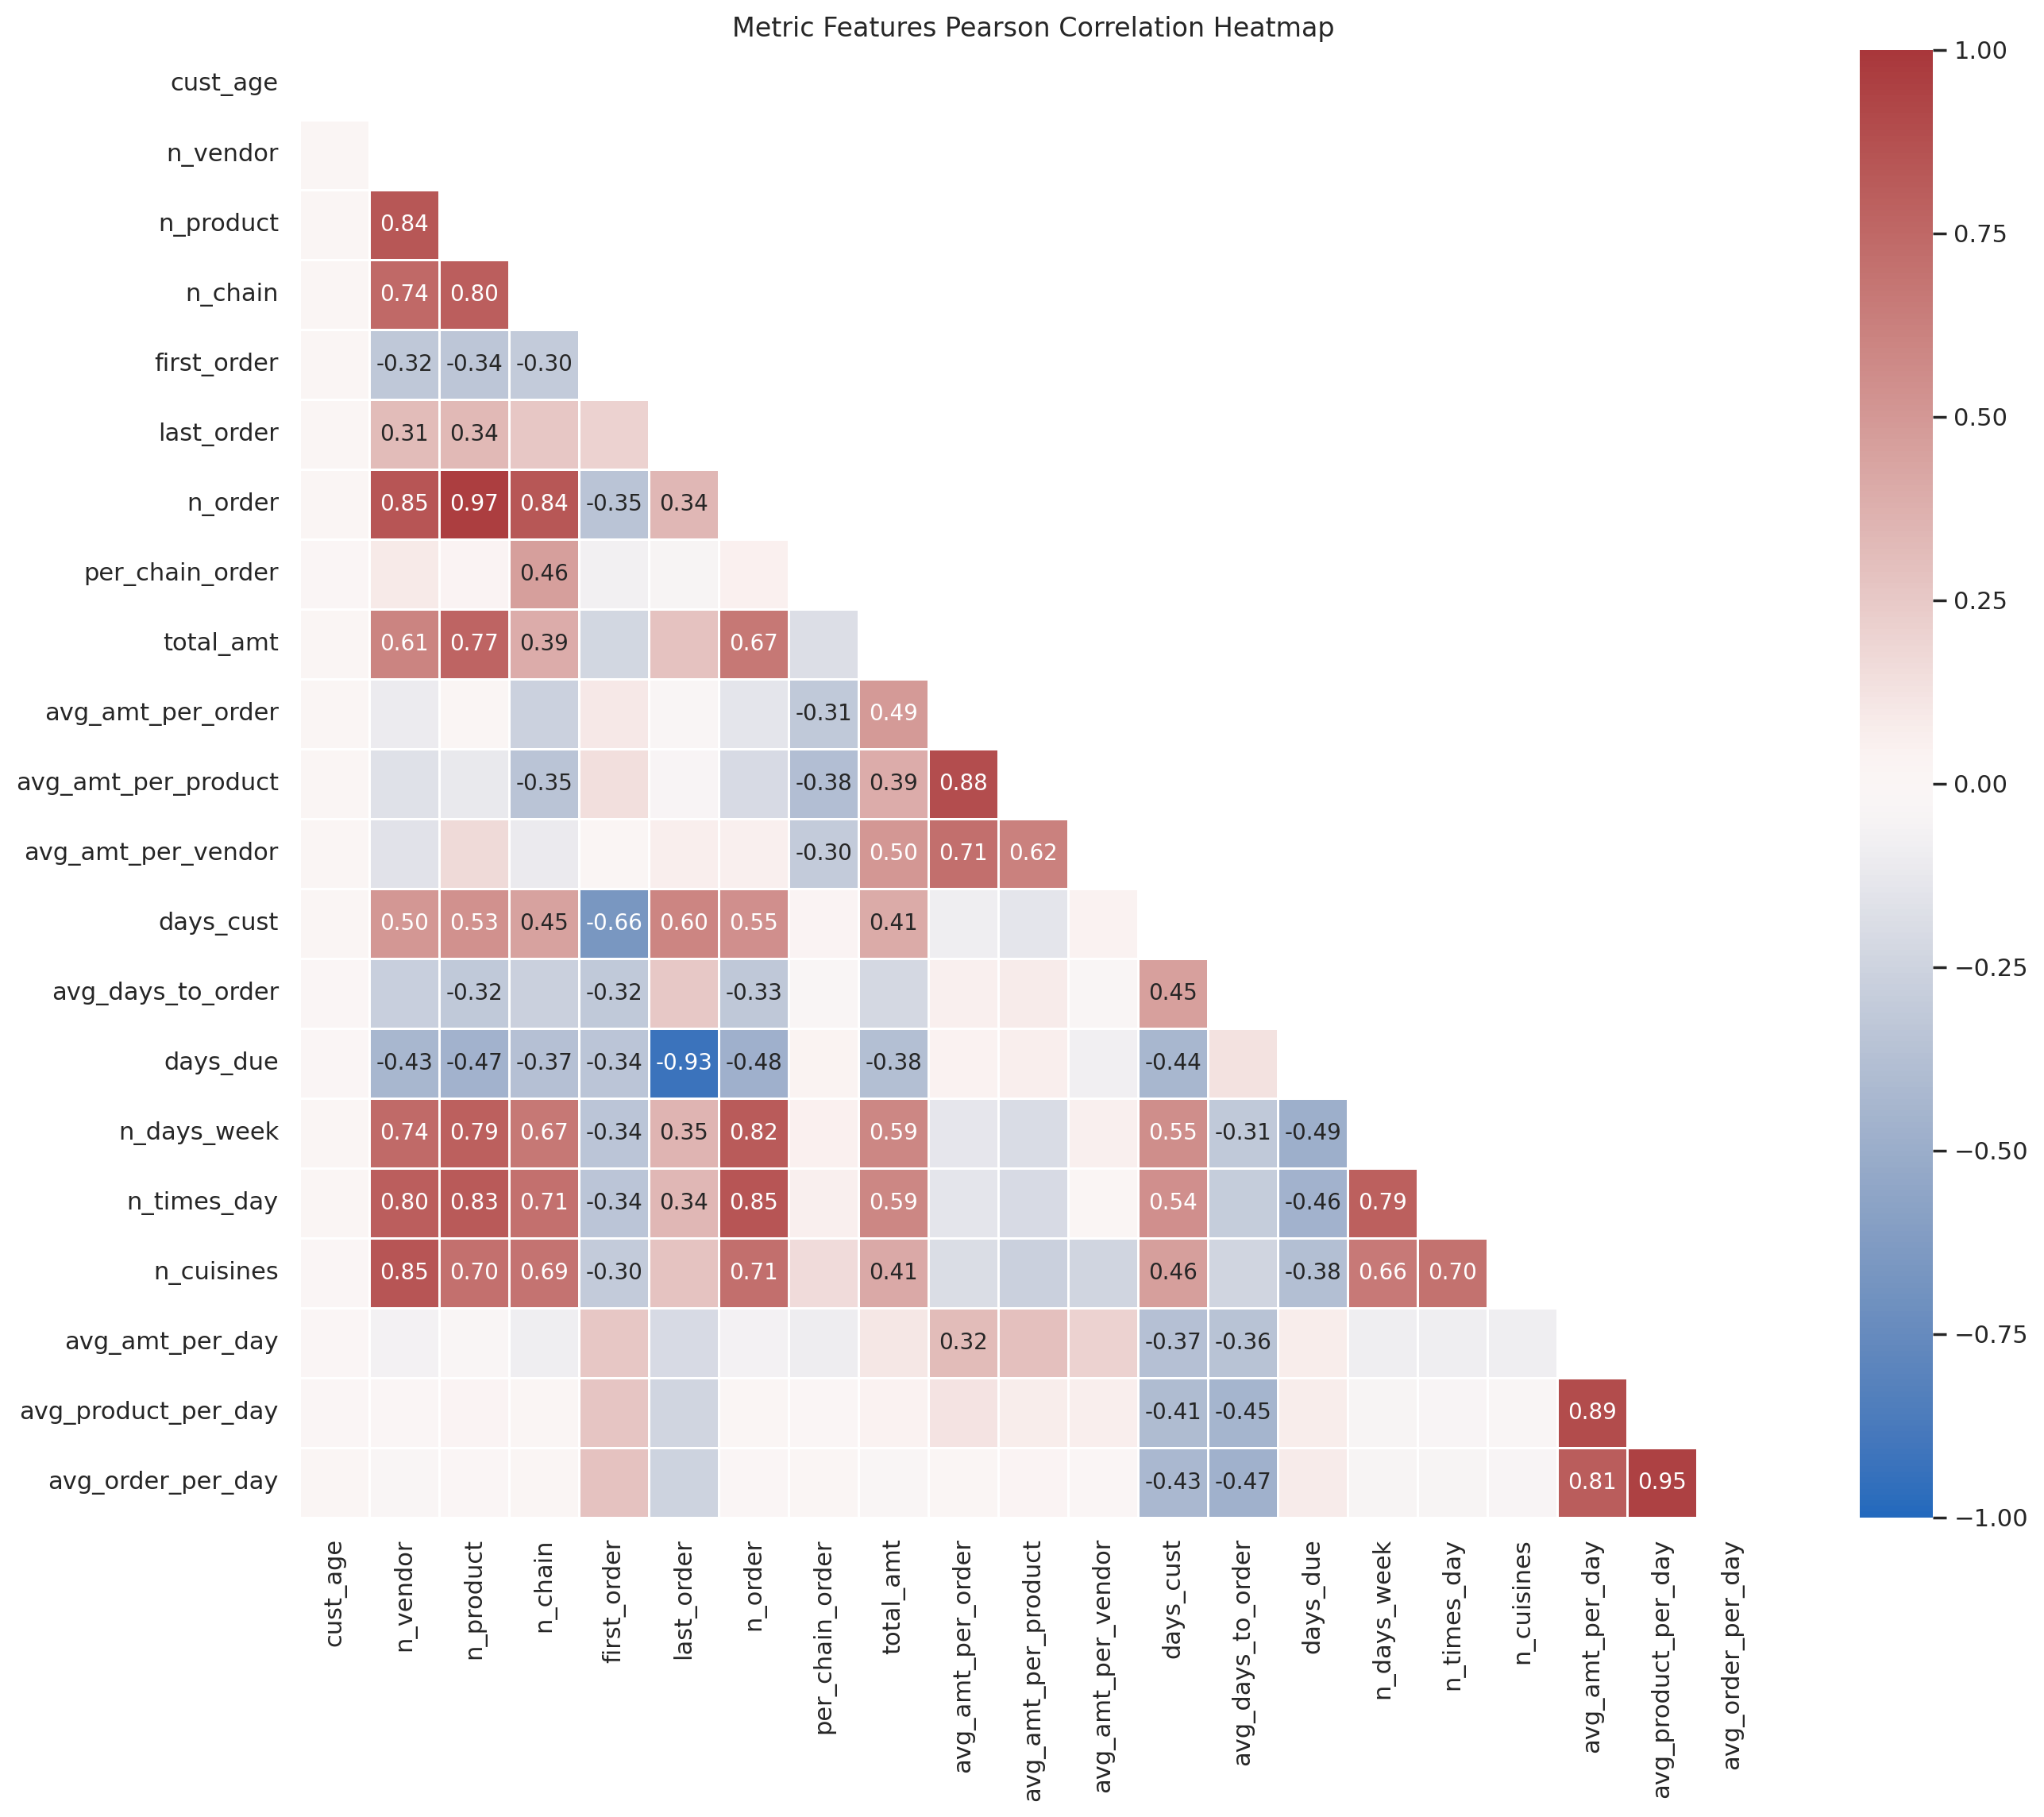

In [142]:
# compute the correlation matrix for the metric features
corr_matrix = data[metric_features].corr(method='pearson')

plt.figure(figsize=(15,12))

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

annot = np.full(corr_matrix.shape, '', dtype=object)

# Fill the annotation array with formatted values for correlations above the threshold
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        if abs(corr_matrix.iat[i, j]) >= 0.3:
            annot[i, j] = f"{corr_matrix.iat[i, j]:.2f}" 

# create the heatmap
sns.heatmap(data=corr_matrix, annot=annot, cmap='vlag', 
            fmt="", center=0, vmin=-1, vmax=1, square=True, 
            linewidths=.5, mask=mask, annot_kws={"size": 10})

# Show the plot
plt.title('Metric Features Pearson Correlation Heatmap')
plt.show()

In [143]:
pca = PCA()
pca_feat = pca.fit_transform(data[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])

In [144]:
# Get the eigenvalues (explained variance)
explained_variance = pca.explained_variance_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# get the cumulative explained variance ratio 
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca.n_components_ + 1)
)

pca_results

,Eigenvalue,Difference,Proportion,Cumulative
1,2.706068,0.000000,0.565395,0.565395
2,1.827410,-0.878658,0.381812,0.947207
3,0.193551,-1.633859,0.040440,0.987647
4,0.037580,-0.155971,0.007852,0.995499
5,0.021543,-0.016037,0.004501,1.000000


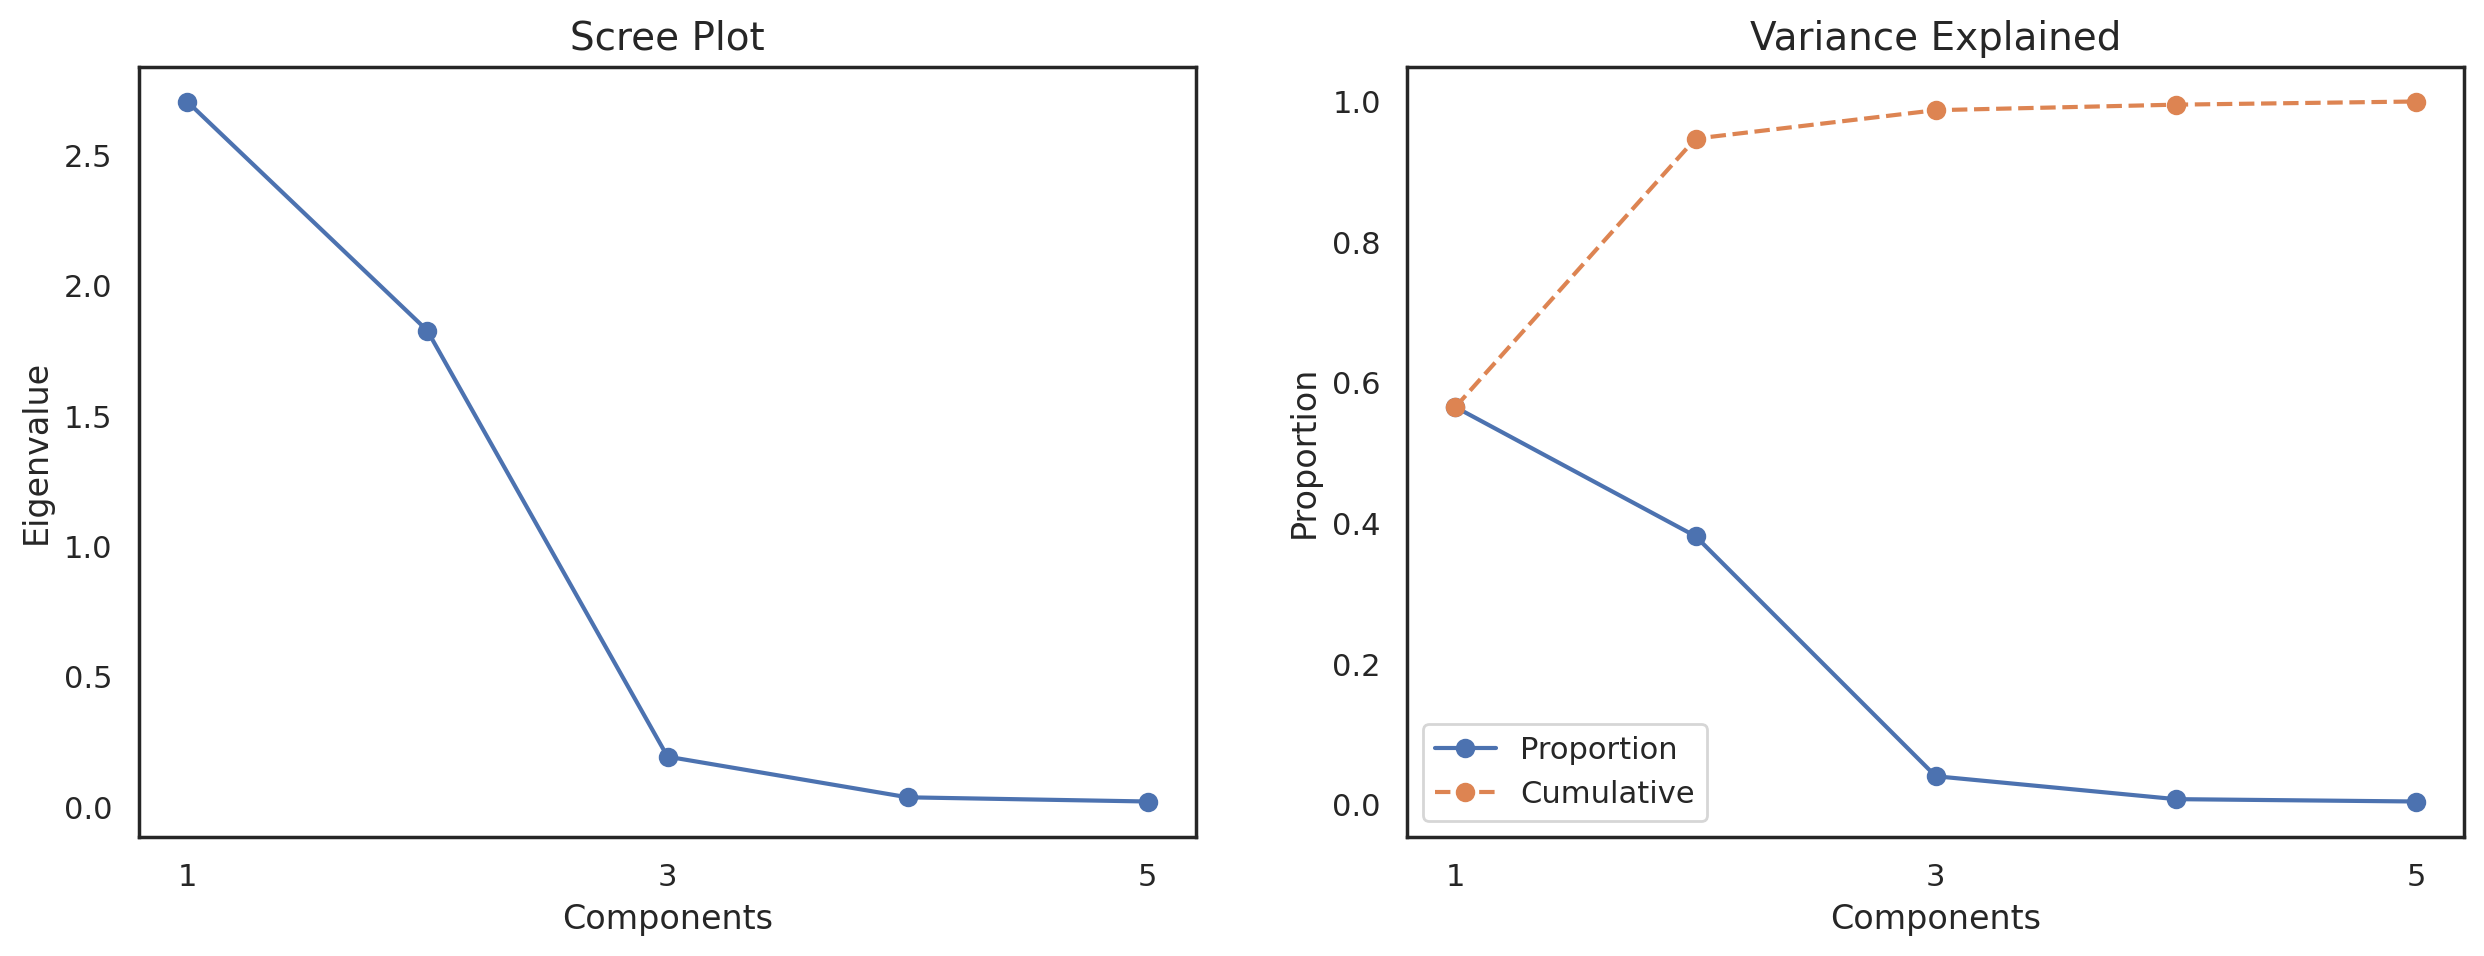

In [145]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots

ax1.plot(explained_variance, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

ax2.plot(explained_variance_ratio,  # PLOT THE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, label="Proportion")

ax2.plot(cumulative_explained_variance_ratio,  # PLOT THE CUMULATIVE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [146]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(data[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

# remember index=df_pca.index
pca_df = pd.DataFrame(pca_feat, index=data.index, columns=pca_feat_names)  
pca_df.head()

,PC0,PC1,PC2
customer_id,,,
118371798366,15.549184,-0.102906,0.299953
400089128395,9.334548,-0.735079,-0.725955
1060080106083,7.706987,-0.700938,-2.941747
103287041752,5.972791,-0.736553,0.861463
338018592517,9.459245,-0.433844,3.151315


In [147]:
pca.explained_variance_ratio_

array([0.5653954 , 0.38181197, 0.04043979])

In [148]:
pd.DataFrame(pca.components_, columns=['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'])

,avg_amt_per_day,avg_product_per_day,avg_order_per_day,n_product,n_order
0,0.566242,0.588263,0.576489,-0.013723,-0.028078
1,-0.011878,0.037959,0.024144,0.706549,0.706133
2,0.770892,-0.148003,-0.606794,0.106701,-0.065093


In [149]:
# Reassigning df to contain pca variables
data = pd.concat([data, pca_df], axis=1)
data.head()

,cust_region,cust_age,n_vendor,n_product,n_chain,first_order,last_order,last_promo,pay_method,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,cust_city,total_amt,n_order,avg_amt_per_product,avg_amt_per_order,avg_amt_per_vendor,days_cust,avg_days_to_order,days_due,per_chain_order,n_days_week,n_times_day,regular,n_cuisines,log_n_vendor,log_n_product,log_n_chain,log_american,log_asian,log_beverages,log_cafe,log_chicken_dishes,log_chinese,log_desserts,log_healthy,log_indian,log_italian,log_japanese,log_noodle_dishes,log_other,log_street_food_snacks,log_thai,log_total_amt,log_n_order,log_avg_amt_per_product,log_avg_amt_per_order,log_avg_amt_per_vendor,log_n_days_week,log_n_times_day,foodie_flag,gluttonous_flag,loyal_flag,top_cuisine,avg_amt_per_day,avg_product_per_day,avg_order_per_day,PC0,PC1,PC2
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118371798366,2360,-1.345900,-0.622187,-0.252742,-0.633329,-1.131842,-3.500568,DELIVERY,DIGI,-0.486170,-0.488927,-0.317568,-0.165088,-0.273312,-0.260873,-0.20627,-0.205561,4.061113,-0.342266,-0.363981,-0.202848,-0.372285,-0.278876,-0.230057,0.356957,-0.646944,-0.674014,-0.689695,-0.73492,-0.705798,0.160186,-0.174681,-0.189373,-0.200666,-0.257385,-0.25538,-0.247911,-0.231751,-0.24215,-0.267549,-0.367063,-0.428853,-0.464903,-0.433021,-0.420768,-0.407075,-0.431283,-0.464805,-0.469156,1.763653,-0.362839,-0.292908,-0.22833,-0.182616,-0.186099,2,-0.332279,-0.700352,-0.337798,0.899607,0.162319,-1.759441,-1.443647,3.025425,-0.387035,-0.792966,-1.213175,True,-1.120173,-0.701528,-0.033868,-0.729523,-0.739557,-0.784371,-0.459818,-0.218988,-0.348461,-0.360903,-0.262785,-0.277907,3.743945,-0.504522,-0.511543,-0.277011,-0.545779,-0.389082,-0.29454,-0.053734,-1.020872,-0.129327,1.050632,0.505462,-0.794926,-1.783859,0,0,0,indian,7.819311,12.574166,6.402312,15.549184,-0.102906,0.299953
400089128395,8670,-1.487186,-0.622187,-0.769539,-0.356817,-1.131842,-3.500568,DISCOUNT,DIGI,0.625611,-0.211512,-0.317568,-0.165088,-0.273312,-0.260873,-0.20627,-0.205561,-0.256206,-0.342266,-0.363981,-0.202848,-0.372285,-0.278876,-0.230057,0.356957,-0.646944,-0.674014,-0.689695,-0.73492,-0.705798,0.160186,-0.174681,-0.189373,-0.200666,-0.257385,-0.25538,-0.247911,-0.231751,-0.24215,-0.267549,-0.367063,0.706668,0.598445,-0.433021,-0.420768,-0.407075,-0.431283,-0.464805,-0.469156,-0.432474,-0.362839,-0.292908,-0.22833,-0.182616,-0.186099,8,-0.573930,-0.700352,0.825949,0.086764,-0.313801,-1.759441,-1.443647,3.025425,1.032029,-0.792966,-0.711543,True,-0.431058,-0.701528,-1.214069,-0.149593,1.329052,0.503190,-0.459818,-0.218988,-0.348461,-0.360903,-0.262785,-0.277907,-0.351143,-0.504522,-0.511543,-0.277011,-0.545779,-0.389082,-0.29454,-0.542400,-1.020872,0.874691,0.367706,-0.086075,-0.794926,-0.763012,0,0,0,american,5.042618,4.670481,6.402312,9.334548,-0.735079,-0.725955
1060080106083,4660,1.479818,-1.003993,-0.769539,-0.356817,-1.131842,-3.500568,DISCOUNT,CASH,0.311676,-0.488927,-0.317568,-0.165088,-0.273312,-0.260873,-0.20627,-0.205561,-0.256206,-0.342266,-0.363981,-0.202848,-0.372285,-0.278876,-0.230057,0.356957,-0.646944,-0.674014,-0.689695,-0.73492,-0.705798,0.160186,-0.174681,-0.189373,-0.200666,-0.257385,-0.25538,-0.247911,-0.231751,-0.24215,-0.267549,1.007813,-0.428853,0.598445,-0.433021,-0.420768,-0.407075,-0.431283,-0.464805,-0.469156,-0.432474,-0.362839,-0.292908,-0.22833,-0.182616,-0.186099,4,-0.824077,-0.700352,-0.695220,-0.754659,-0.353682,-1.759441,-1.443647,3.025425,1.032029,-0.792966,-0.711543,True,-1.120173,-1.594480,-1.214069,-0.149593,1.089803,-0.784371,-0.459818,-0.218988,-0.348461,-0.360903,-0.262785,-0.277907,-0.351143,-0.504522,-0.511543,-0.277011,-0.545779,-0.389082,-0.29454,-1.39

In [150]:
loadings = data[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'] + pca_feat_names].corr().loc[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'], pca_feat_names]

In [151]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: #ffbdbd'
    elif val > 0.45:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings.style.map(_color_red_or_green)

,PC0,PC1,PC2
avg_amt_per_day,0.938126,-0.016171,0.341571
avg_product_per_day,0.986600,0.052315,-0.066384
avg_order_per_day,0.958019,0.032972,-0.269682
n_product,-0.023418,0.990780,0.048695
n_order,-0.047920,0.990356,-0.029711


In [152]:
data.drop(columns='PC2', inplace=True)

In [153]:
data.rename(columns={'PC0': 'transaction_volume', 'PC1': 'interaction_rate'}, inplace=True)

In [154]:
data.head()

,cust_region,cust_age,n_vendor,n_product,n_chain,first_order,last_order,last_promo,pay_method,american,asian,beverages,cafe,chicken_dishes,chinese,desserts,healthy,indian,italian,japanese,noodle_dishes,other,street_food_snacks,thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,cust_city,total_amt,n_order,avg_amt_per_product,avg_amt_per_order,avg_amt_per_vendor,days_cust,avg_days_to_order,days_due,per_chain_order,n_days_week,n_times_day,regular,n_cuisines,log_n_vendor,log_n_product,log_n_chain,log_american,log_asian,log_beverages,log_cafe,log_chicken_dishes,log_chinese,log_desserts,log_healthy,log_indian,log_italian,log_japanese,log_noodle_dishes,log_other,log_street_food_snacks,log_thai,log_total_amt,log_n_order,log_avg_amt_per_product,log_avg_amt_per_order,log_avg_amt_per_vendor,log_n_days_week,log_n_times_day,foodie_flag,gluttonous_flag,loyal_flag,top_cuisine,avg_amt_per_day,avg_product_per_day,avg_order_per_day,transaction_volume,interaction_rate
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118371798366,2360,-1.345900,-0.622187,-0.252742,-0.633329,-1.131842,-3.500568,DELIVERY,DIGI,-0.486170,-0.488927,-0.317568,-0.165088,-0.273312,-0.260873,-0.20627,-0.205561,4.061113,-0.342266,-0.363981,-0.202848,-0.372285,-0.278876,-0.230057,0.356957,-0.646944,-0.674014,-0.689695,-0.73492,-0.705798,0.160186,-0.174681,-0.189373,-0.200666,-0.257385,-0.25538,-0.247911,-0.231751,-0.24215,-0.267549,-0.367063,-0.428853,-0.464903,-0.433021,-0.420768,-0.407075,-0.431283,-0.464805,-0.469156,1.763653,-0.362839,-0.292908,-0.22833,-0.182616,-0.186099,2,-0.332279,-0.700352,-0.337798,0.899607,0.162319,-1.759441,-1.443647,3.025425,-0.387035,-0.792966,-1.213175,True,-1.120173,-0.701528,-0.033868,-0.729523,-0.739557,-0.784371,-0.459818,-0.218988,-0.348461,-0.360903,-0.262785,-0.277907,3.743945,-0.504522,-0.511543,-0.277011,-0.545779,-0.389082,-0.29454,-0.053734,-1.020872,-0.129327,1.050632,0.505462,-0.794926,-1.783859,0,0,0,indian,7.819311,12.574166,6.402312,15.549184,-0.102906
400089128395,8670,-1.487186,-0.622187,-0.769539,-0.356817,-1.131842,-3.500568,DISCOUNT,DIGI,0.625611,-0.211512,-0.317568,-0.165088,-0.273312,-0.260873,-0.20627,-0.205561,-0.256206,-0.342266,-0.363981,-0.202848,-0.372285,-0.278876,-0.230057,0.356957,-0.646944,-0.674014,-0.689695,-0.73492,-0.705798,0.160186,-0.174681,-0.189373,-0.200666,-0.257385,-0.25538,-0.247911,-0.231751,-0.24215,-0.267549,-0.367063,0.706668,0.598445,-0.433021,-0.420768,-0.407075,-0.431283,-0.464805,-0.469156,-0.432474,-0.362839,-0.292908,-0.22833,-0.182616,-0.186099,8,-0.573930,-0.700352,0.825949,0.086764,-0.313801,-1.759441,-1.443647,3.025425,1.032029,-0.792966,-0.711543,True,-0.431058,-0.701528,-1.214069,-0.149593,1.329052,0.503190,-0.459818,-0.218988,-0.348461,-0.360903,-0.262785,-0.277907,-0.351143,-0.504522,-0.511543,-0.277011,-0.545779,-0.389082,-0.29454,-0.542400,-1.020872,0.874691,0.367706,-0.086075,-0.794926,-0.763012,0,0,0,american,5.042618,4.670481,6.402312,9.334548,-0.735079
1060080106083,4660,1.479818,-1.003993,-0.769539,-0.356817,-1.131842,-3.500568,DISCOUNT,CASH,0.311676,-0.488927,-0.317568,-0.165088,-0.273312,-0.260873,-0.20627,-0.205561,-0.256206,-0.342266,-0.363981,-0.202848,-0.372285,-0.278876,-0.230057,0.356957,-0.646944,-0.674014,-0.689695,-0.73492,-0.705798,0.160186,-0.174681,-0.189373,-0.200666,-0.257385,-0.25538,-0.247911,-0.231751,-0.24215,-0.267549,1.007813,-0.428853,0.598445,-0.433021,-0.420768,-0.407075,-0.431283,-0.464805,-0.469156,-0.432474,-0.362839,-0.292908,-0.22833,-0.182616,-0.186099,4,-0.824077,-0.700352,-0.695220,-0.754659,-0.353682,-1.759441,-1.443647,3.025425,1.032029,-0.792966,-0.711543,True,-1.120173,-1.594480,-1.214069,-0.149593,1.089803,-0.784371,-0.459818,-0.218988,-0.348461,-0.360903,-0.262785,-0.277907,-0.351143,-0.504522,-0.511543,-0.277011,-0.545779,-0.389082,-0.29454,-

## 4.6. Factor Analysis

In [155]:
fa_variables = [
    'log_american',
    'log_asian',
    'log_beverages',
    'log_cafe',
    'log_chicken_dishes',
    'log_chinese',
    'log_desserts',
    'log_healthy',
    'log_indian',
    'log_italian',
    'log_japanese',
    'log_noodle_dishes',
    'log_other',
    'log_street_food_snacks',
    'log_thai',
    # 'log_total_amt',
    # 'log_avg_amt_per_product',
    # 'log_avg_amt_per_order',
    # 'log_avg_amt_per_vendor',
    # 'transaction_volume',
    # 'interaction_rate'
]

fa_data = data[fa_variables]

# 5. Clustering

## 5.1. Spending and Order Diversity Clustering

In [156]:
spending_diversity = ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']

In [157]:
spending_diversity_std_df = data[spending_diversity]

In [158]:
# Function to calculate R² for a clustering solution
def get_rsq(df, features, label_column):
    """Calculates R² for a clustering solution.
    
    R² = SSb / SSt
    where:
    SSb = between-group sum of squares
    SSt = total sum of squares
    
    Parameters:
    df (DataFrame): The dataframe containing the features and cluster labels
    features (list): List of feature columns to consider
    label_column (str): The column containing the cluster labels
    
    Returns:
    float: R² value indicating homogeneity of the clusters
    """
    # Total Sum of Squares (SSt)
    mean = df[features].mean().values
    sst = np.sum((df[features].values - mean) ** 2)

    # Between-group Sum of Squares (SSb)
    ssb = 0
    for label in df[label_column].unique():
        group = df[df[label_column] == label]
        group_mean = group[features].mean().values
        ssb += len(group) * np.sum((group_mean - mean) ** 2)
        
    # R² Calculation
    r2 = ssb / sst if sst != 0 else 0
    return r2

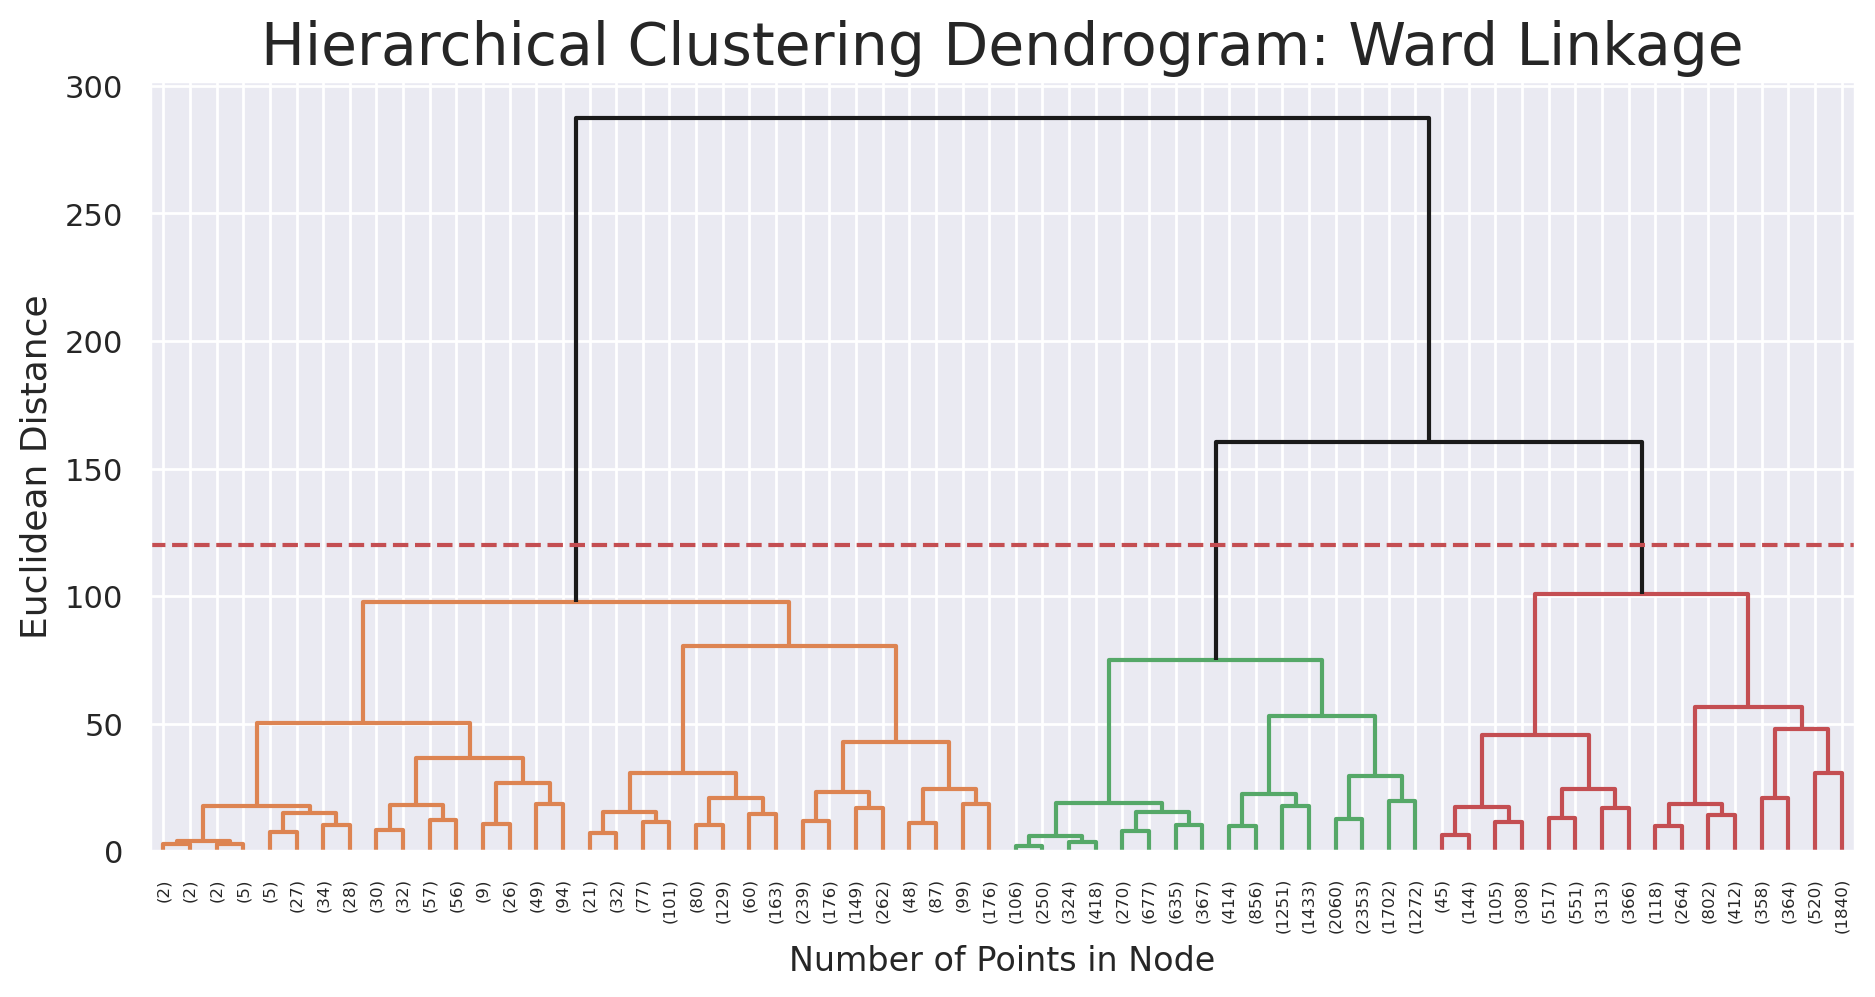

In [159]:
# Plotting the Dendrogram for Hierarchical Clustering
# Using the 'ward' method for dendrogram plotting (you can adjust this method)
linkage_matrix = linkage(spending_diversity_std_df.values, method="ward", metric="euclidean")

sns.set()
fig = plt.figure(figsize=(11, 5))
# Set a threshold for cutting the dendrogram
y_threshold = 120
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
plt.xlabel('Number of Points in Node')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [160]:
avg_silhouette = []
for nclus in range(3, 9):
    # Skip nclus == 1
    if nclus == 1:
        continue

    cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward")
    hc_labels = cluster.fit_predict(spending_diversity_std_df)

    # Calculate centroids based on these hierarchical clusters
    centroids = []
    for i in range(nclus):
        cluster_points = spending_diversity_std_df[hc_labels == i]  # Get points belonging to cluster i
        centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
        centroids.append(centroid)

    centroids = np.array(centroids)

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
    cluster_labels = kmclust.fit_predict(spending_diversity_std_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(spending_diversity_std_df, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 3, the average silhouette_score is : 0.4701518426935238
For n_clusters = 4, the average silhouette_score is : 0.45706446878020435
For n_clusters = 5, the average silhouette_score is : 0.38995858650018156
For n_clusters = 6, the average silhouette_score is : 0.337331573098276
For n_clusters = 7, the average silhouette_score is : 0.3748553040349577
For n_clusters = 8, the average silhouette_score is : 0.34782455734534884


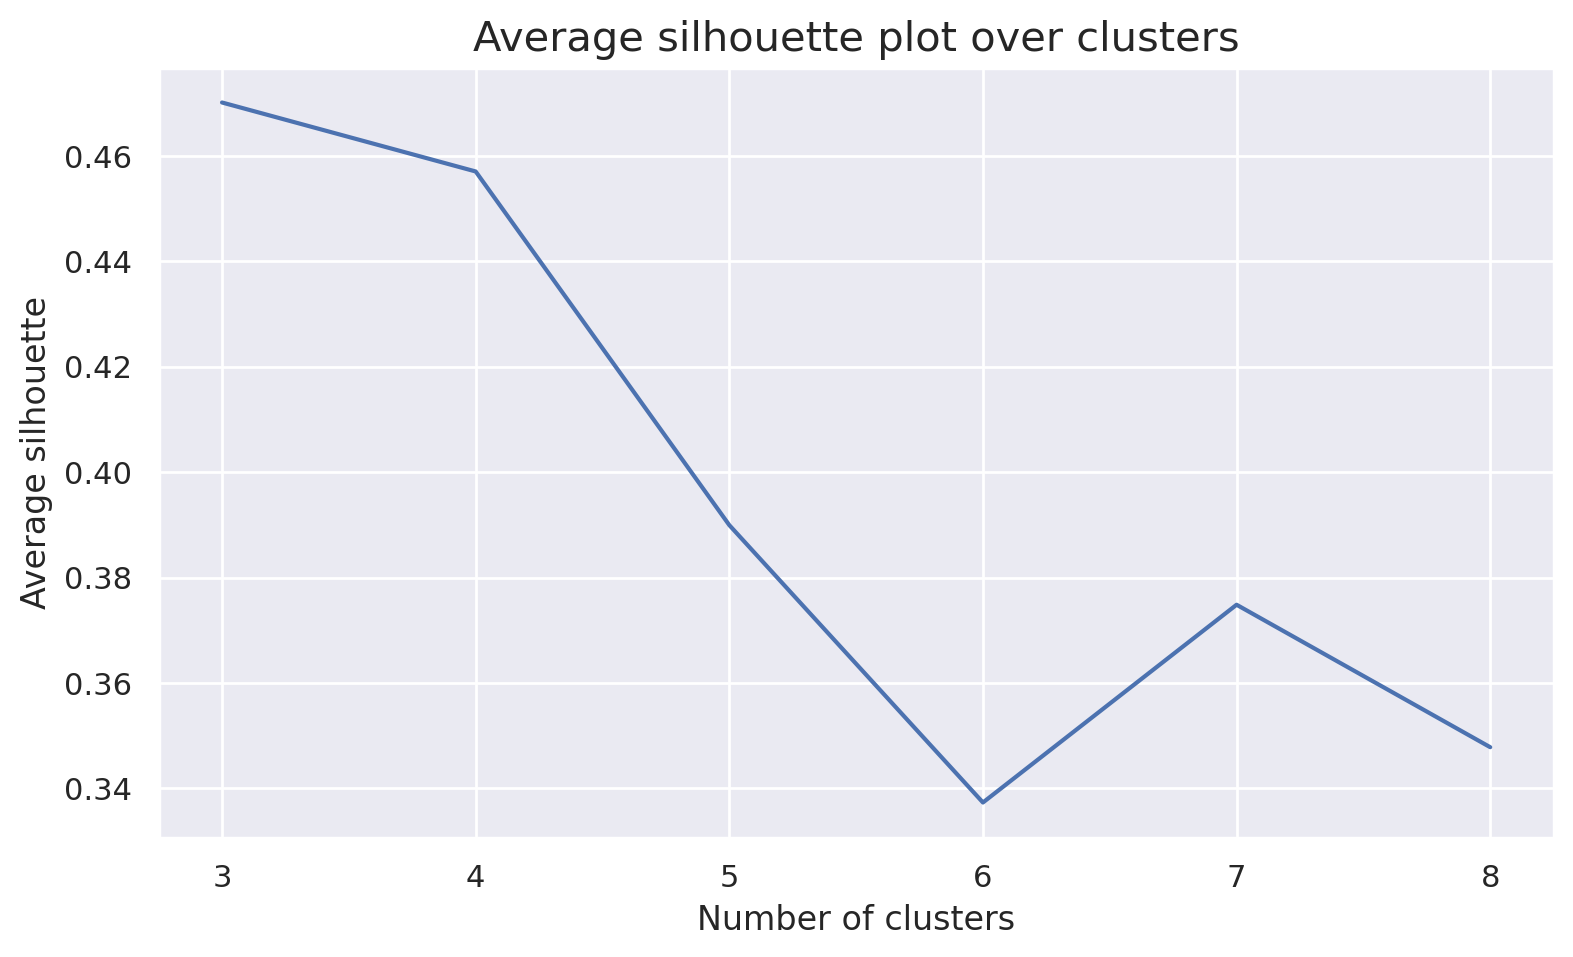

In [161]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))

#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range(3, 9), ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [162]:
n_clusters = 3

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(spending_diversity_std_df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = spending_diversity_std_df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)

In [163]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(spending_diversity_std_df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(spending_diversity_std_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4701518426935238


In [164]:
df_concat = pd.concat([
    spending_diversity_std_df, 
    pd.Series(hc_labels, name='labels', index=spending_diversity_std_df.index)
    ], 
    axis=1)

df_concat.groupby('labels').median()

,total_amt,n_cuisines,n_vendor,n_product
labels,,,,
0,0.287966,0.258057,0.141425,0.091790
1,1.557196,1.636288,2.050455,1.814447
2,-0.570681,-0.431058,-0.622187,-0.597273


KeyError: 'labels'

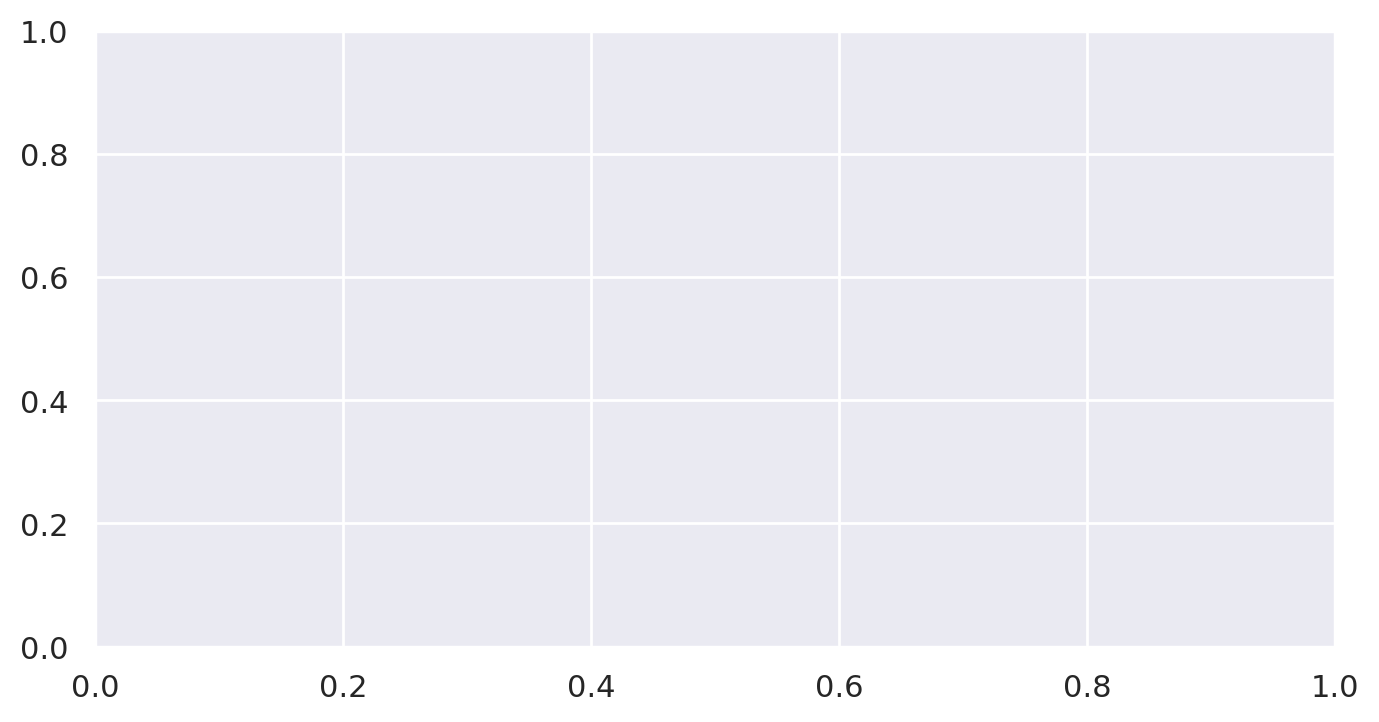

In [165]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = data.groupby('labels').median().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()

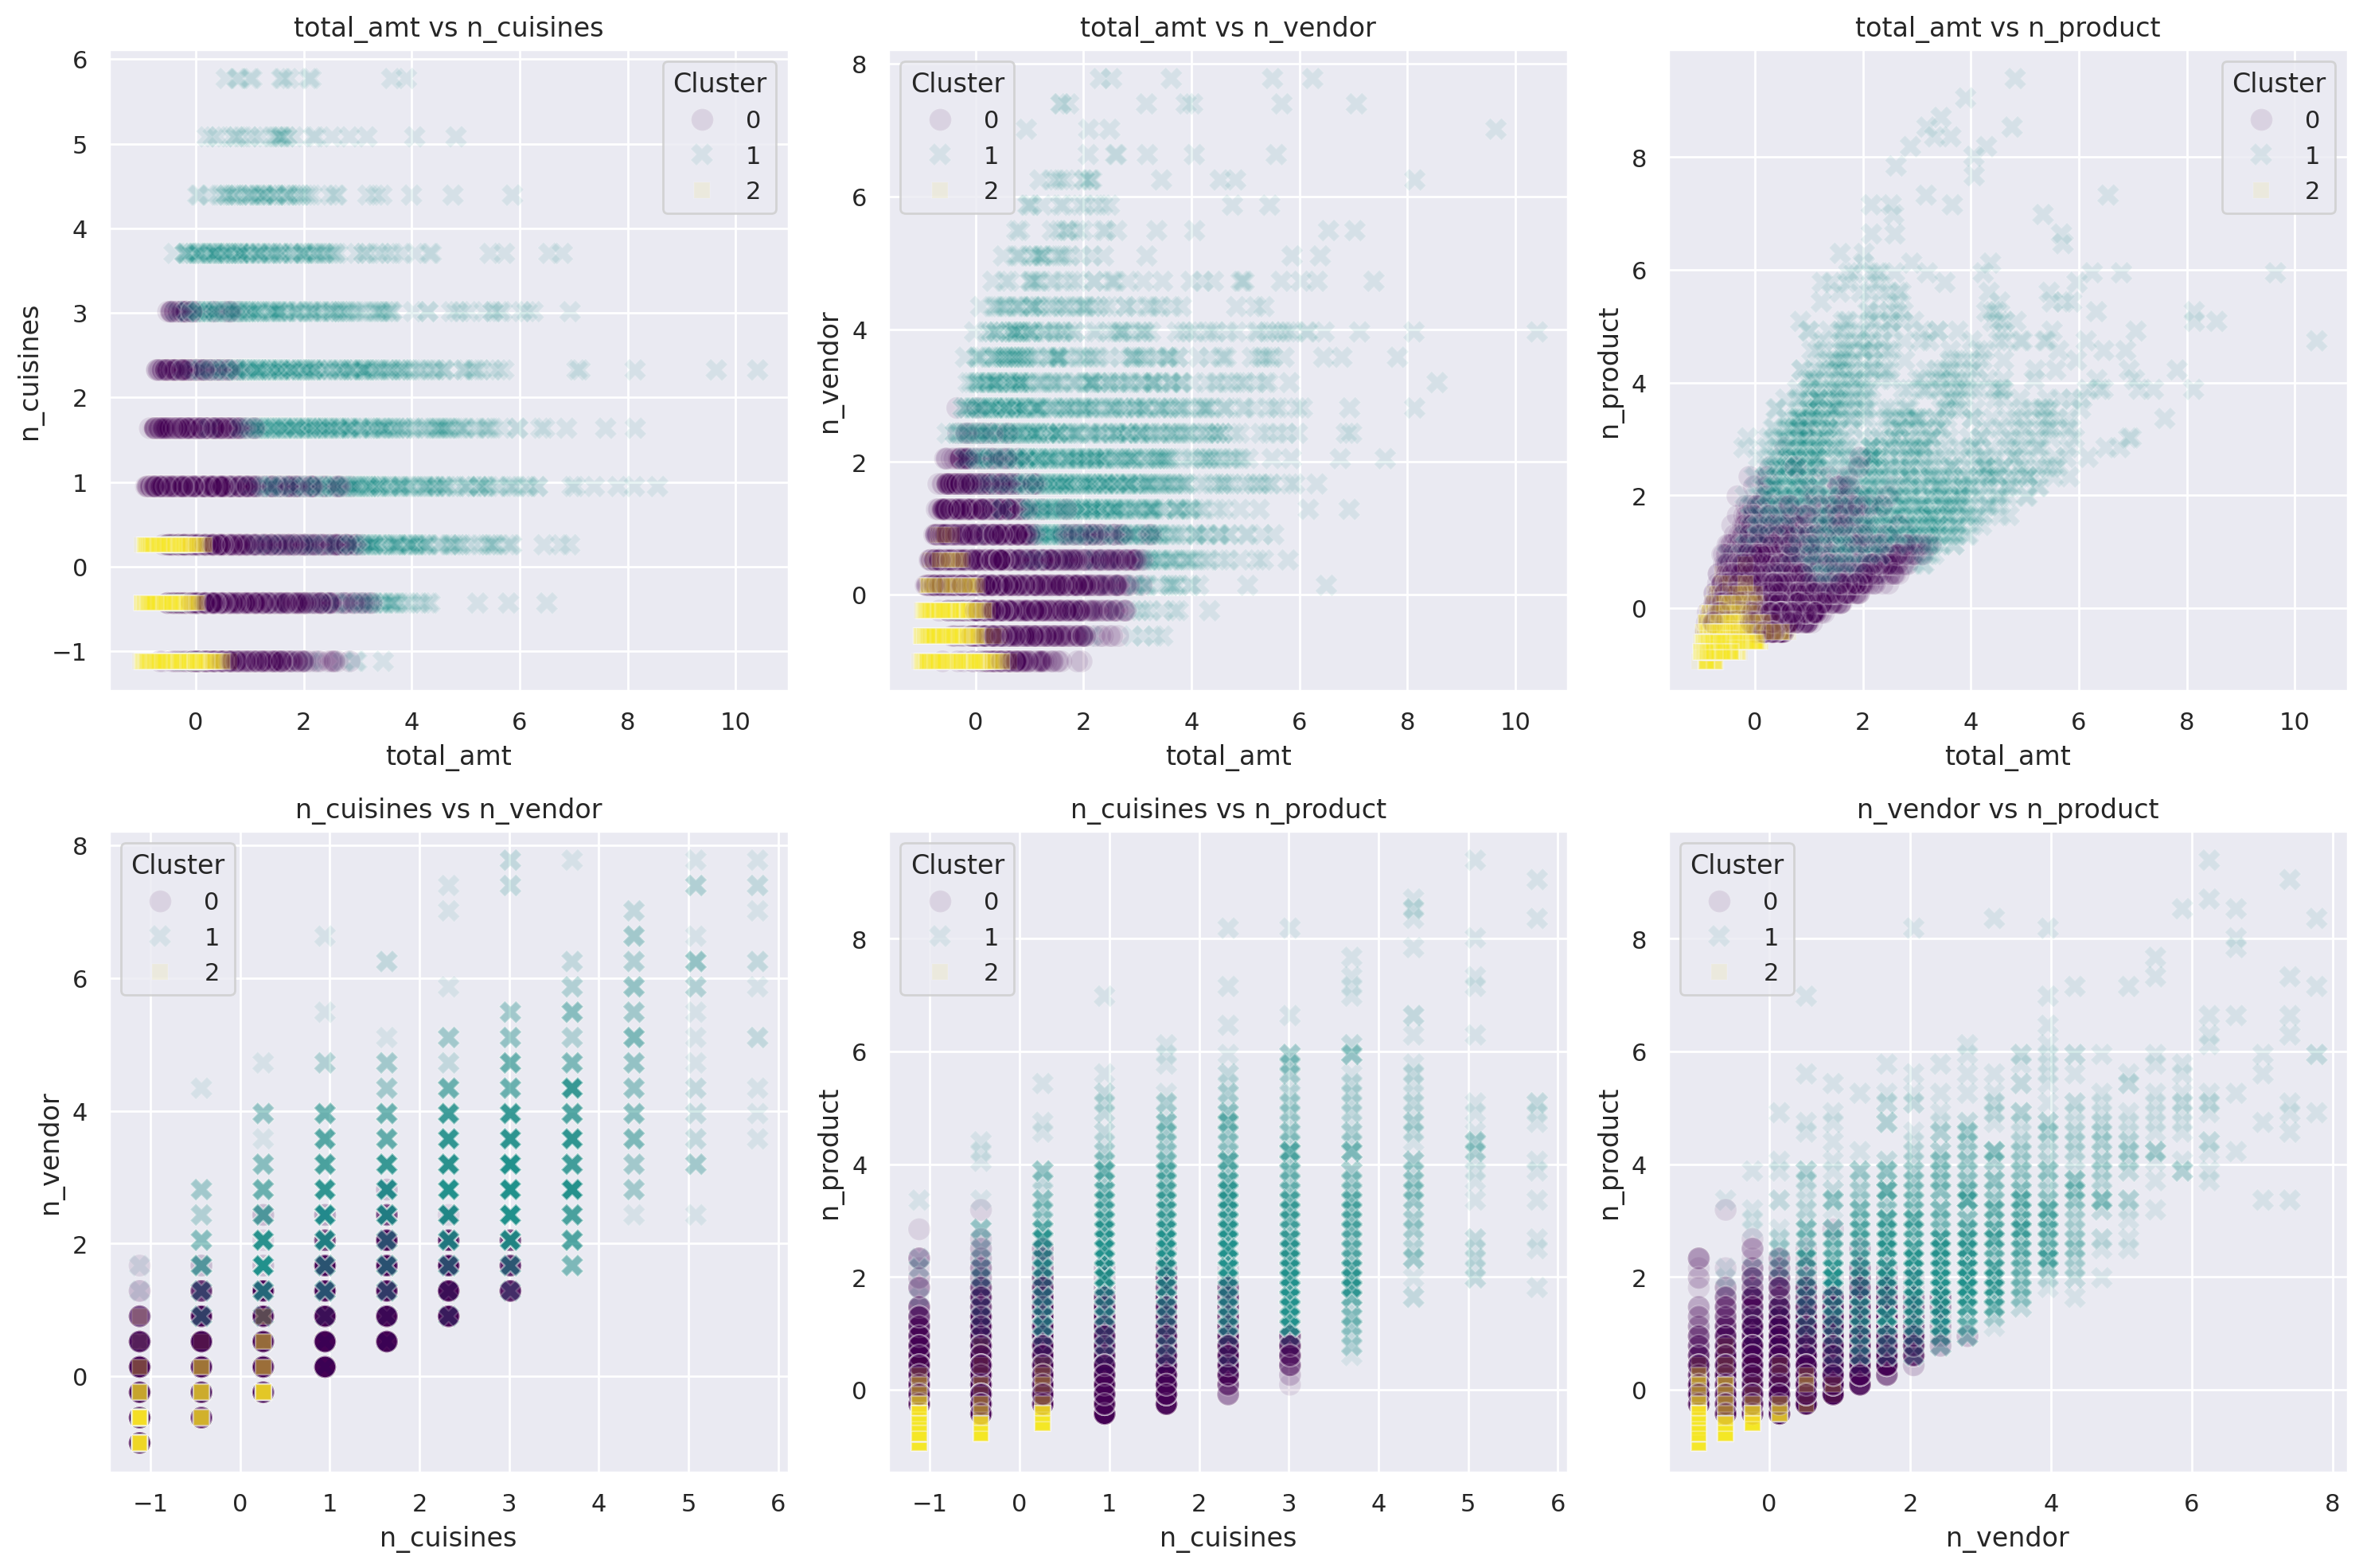

In [103]:
import itertools

combinations = list(itertools.combinations(df_concat.columns[:-1], 2))
n_combinations = len(combinations)

# Step 3: Set up subplots
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Step 4: Plot each combination
for ax, (feature_x, feature_y) in zip(axes.flatten(), combinations):
    sns.scatterplot(
        data=df_concat,
        x=feature_x,
        y=feature_y,
        hue='labels',  # Cluster labels
        palette='viridis',
        style='labels',  # Optional: use style for labels too
        s=100,  # Point size
        alpha=0.1,  # Transparency
        ax=ax
    )
    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(title="Cluster", loc='best')
    ax.grid(True)

# Remove any empty subplots
for i in range(n_combinations, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

In [107]:
# Group by 'labels' and compute the mean for 'last_promo', excluding 'NO_PROMO'
cluster_profile = df_concat[df_concat['last_promo'] != 'NO_PROMO']\
    .groupby('labels')['last_promo'].mean().reset_index()

# Display cluster profiling
print("Cluster Profiling Based on Last Promo (excluding 'NO_PROMO'):")
print(cluster_profile)


KeyError: 'last_promo'

In [84]:

# Create an empty DataFrame to store results
result_list = []

# Loop through each promo column to filter and compute medians
for promo in promo_columns:
    # Filter customers with non-zero values for the specific promo column
    filtered_df = df_concat[df_concat[promo] > 0]
    
    # Group by 'labels' and compute the median 'total_amt' for this promo
    median_total_amt = (
        filtered_df
        .groupby('labels')['total_amt']
        .median()
        .reset_index()
    )
    
    # Add the promo column name for clarity
    median_total_amt['promo_type'] = promo
    result_list.append(median_total_amt)

# Concatenate results for all promos
final_result = pd.concat(result_list, ignore_index=True)

# Display results
print("Median Total Amount by Labels and Promo Types:")
display(final_result)

ValueError: No objects to concatenate

In [ ]:
df_means = df_concat.mean()
df_means.name="Data"

pd.concat([hc_profile, 
           df_means], axis=1
)